In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)

eSOH_DIR = "../data/esoh/"
oCV_DIR = "../data/ocv/"
hppc_DIR = "../data/hppc/"
crate_DIR = "../data/crate/"
fig_DIR = "../figures/"
res_DIR = "../data/results/"

%matplotlib widget

In [2]:
spm = pybamm.lithium_ion.SPMe(
    {
        # "SEI": "ec reaction limited",
        # # "loss of active material": ("stress-driven","none"),
        # "loss of active material": "stress-driven",
        # "stress-induced diffusion": "true",
        # "lithium plating": "reversible",
    }
)
# spm.print_parameter_info()
param=spm.param

In [3]:
parameter_values = get_parameter_values()

In [4]:
cell = 1
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")

In [5]:
parameter_values = get_parameter_values()
parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": 1.2676e-07,#2.7081e-07, #4.1759e-07,#2.7081e-07, #2.5112e-07,
        "Negative electrode LAM constant proportional term [s-1]": 1.2713e-06,#3.7576e-06, #3.2693e-06,#3.7576e-06, #2.4741e-06,
        "Positive electrode LAM constant exponential term": 1.1998,#1.2446,#1.2232,#1.1942,
        "Negative electrode LAM constant exponential term": 1.1998,#1.2446,#1.2232,#1.1942,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "SEI kinetic rate constant [m.s-1]": 1.08494281e-16,
        "EC diffusivity [m2.s-1]": 8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 1.58777981e+04,
        # "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        # "EC diffusivity [m2.s-1]": 2e-18,
        # "SEI growth activation energy [J.mol-1]": 0,
    },
    check_already_exists=False,
)

In [ ]:
hppc_data_raw = pd.read_csv(hppc_DIR+'hppc_data_cell_'+cell_no+'.csv')
hppc_data_raw = hppc_data_raw[ hppc_data_raw['Cycle number'] == 0 ]

In [ ]:
idx_hppc = hppc_data_raw['Current [mA]'].lt(0).idxmax()
hppc_data = hppc_data_raw.iloc[idx_hppc:,:]
hppc_data = hppc_data.reset_index(drop=True)

In [ ]:
data_time = hppc_data['Time [s]']-hppc_data['Time [s]'][0]
data_time = data_time.values
data_current = hppc_data['Current [mA]']/1000
data_current = data_current.values
data_voltage = hppc_data['Voltage [V]']
data_voltage = data_voltage.values

In [ ]:
timescale = parameter_values.evaluate(spm.timescale)
current_interpolant = pybamm.Interpolant(
  #  drive_cycle[:, 0], drive_cycle[:, 1], timescale * pybamm.t
  data_time, -data_current, timescale * pybamm.t
)

In [ ]:
# spm.default_var_pts

In [ ]:
var_pts = {
    'x_n': 30,
    'x_s': 30,
    'x_p': 30,
    'r_n': 60,
    'r_p': 60,
    'r_n_prim': 60,
    'r_p_prim': 60,
    'r_n_sec': 60,
    'r_p_sec': 60,
    'y': 20,
    'z': 20,
    'R_n': 60,
    'R_p': 60,
 }

In [ ]:
pybamm.set_logging_level("NOTICE")
parameter_values["Current function [A]"] = current_interpolant
# var_pts=var_pts,
sim = pybamm.Simulation(spm, 
                        parameter_values=parameter_values, 
                        solver=pybamm.CasadiSolver(mode="safe", rtol=1e-8, atol=1e-8,)
                        )
sim.solve(t_eval=data_time,initial_soc =1)
solution = sim.solution

In [ ]:
t = solution["Time [s]"].entries
V = solution["Terminal voltage [V]"].entries
I = solution["Current [A]"].entries
Q = -solution['Discharge capacity [A.h]'].entries

In [110]:
def graphite_diffusivity(sto, T):
    from pybamm import exp, constants
    # D_ref = 5.0 * 10 ** (-15)
    D_ref = 5.0/2* 10 ** (-15)
    E_D_s = 42770
    arrhenius = exp(E_D_s / constants.R * (1 / 298.15 - 1 / T))

    return D_ref * arrhenius

def NMC_diffusivity(sto, T):
    from pybamm import exp, constants
    # D_ref = 8 * 10 ** (-15)
    D_ref = 1.5 * 10 ** (-15)
    E_D_s = 18550
    arrhenius = exp(E_D_s / constants.R * (1 / 298.15 - 1 / T))

    return D_ref * arrhenius

In [111]:
parameter_values.update(
    {
        "Negative electrode diffusivity [m2.s-1]": graphite_diffusivity,
        "Positive electrode diffusivity [m2.s-1]": NMC_diffusivity,

    },
    check_already_exists=False,
)

In [112]:
sim = pybamm.Simulation(spm, parameter_values=parameter_values, solver=pybamm.CasadiSolver(mode="safe"))
sim.solve(t_eval=data_time,initial_soc =1)
solution1 = sim.solution

In [113]:
t1 =  solution1["Time [s]"].entries
V1 =  solution1["Terminal voltage [V]"].entries
I1 =  solution1["Current [A]"].entries
Q1 = -solution1['Discharge capacity [A.h]'].entries

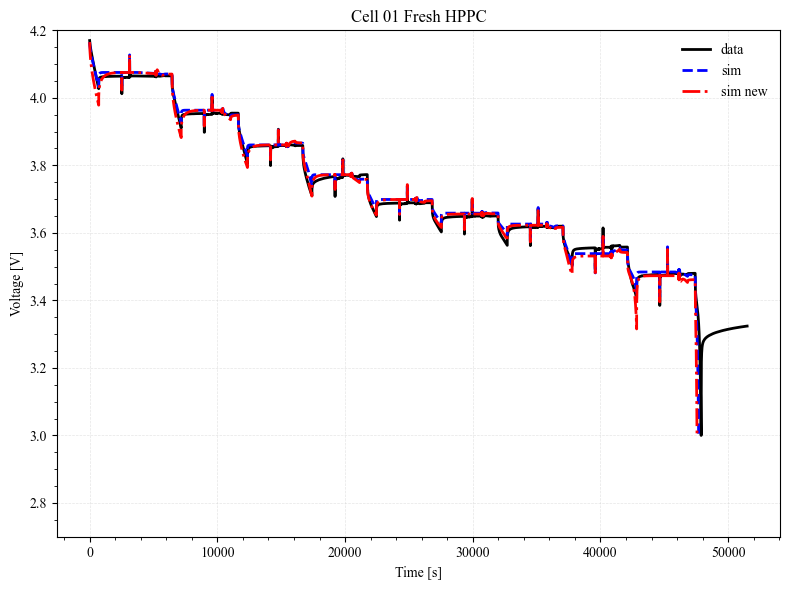

In [114]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6), sharex=True)
ax1.plot(data_time, data_voltage, 'k')
ax1.plot(t, V, 'b--')
ax1.plot(t1, V1, 'r-.')
ax1.set_ylabel("Voltage [V]")
ax1.set_title("Cell 01 Fresh HPPC")
ax1.set_ylim([2.7,4.2])
ax1.set_xlabel("Time [s]")
# ax1.set_xlim([20370,20470])
ax1.legend(['data','sim','sim new'])
fig.tight_layout()
plt.show()
# plt.savefig('cell_01_hppc_fit.png')

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(4, 4), sharex=True)
ax1.plot(data_time, -data_current, 'k', t, I, 'r--')
ax1.set_title("Current [A]")
# ax1.set_ylim([3.9,4.12])
ax1.set_xlabel("Time [s]")
# ax1.set_xlim([20370,20470])
ax1.legend(['data','sim'])
fig.tight_layout()
plt.show()
# plt.savefig('cell_01_hppc_fit.png')

In [ ]:
asdasdasdasd

In [ ]:
crate_data_raw = pd.read_csv(crate_DIR+'crate_data_cell_'+cell_no+'.csv')
crate_data_raw = crate_data_raw[ crate_data_raw['Cycle number'] == 0 ]

In [ ]:
# idx_crate = crate_data_raw['Current [mA]'].gt(0).idxmax()
# crate_data = crate_data_raw.iloc[idx_crate:,:]
# crate_data = crate_data.reset_index(drop=True)

In [ ]:
crate_data = crate_data_raw

In [ ]:
t_d1 = crate_data['Time [s]']-crate_data['Time [s]'][0]
t_d1 = t_d1.values
I_d1 = crate_data['Current [mA]']/1000
I_d1 = I_d1.values
V_d1 = crate_data['Voltage [V]']
V_d1 = V_d1.values

In [ ]:
idx_I = np.where(np.sign(I_d1[:-1]) != np.sign(I_d1[1:]))[0] + 1
idx_I = idx_I[idx_I>50]

In [ ]:
# C/10
nn = 0
t_d1_c10 = t_d1[idx_I[nn+0]:idx_I[nn+1]]-t_d1[idx_I[nn+0]]
I_d1_c10 = I_d1[idx_I[nn+0]:idx_I[nn+1]]
V_d1_c10 = V_d1[idx_I[nn+0]:idx_I[nn+1]]
# C/5
nn = 4
t_d1_c5 = t_d1[idx_I[nn+0]:idx_I[nn+1]]-t_d1[idx_I[nn+0]]
I_d1_c5 = I_d1[idx_I[nn+0]:idx_I[nn+1]]
V_d1_c5 = V_d1[idx_I[nn+0]:idx_I[nn+1]]
# C/2
nn = 8
t_d1_c2 = t_d1[idx_I[nn+0]:idx_I[nn+1]]-t_d1[idx_I[nn+0]]
I_d1_c2 = I_d1[idx_I[nn+0]:idx_I[nn+1]]
V_d1_c2 = V_d1[idx_I[nn+0]:idx_I[nn+1]]
# 1C
nn = 12
t_d1_c1 = t_d1[idx_I[nn+0]:idx_I[nn+1]]-t_d1[idx_I[nn+0]]
I_d1_c1 = I_d1[idx_I[nn+0]:idx_I[nn+1]]
V_d1_c1 = V_d1[idx_I[nn+0]:idx_I[nn+1]]

In [ ]:
# fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
# ax1 = axes.flat[0]
# # ax1.plot(crate_data['Time [s]'],crate_data['Voltage [V]'])
# ax1.plot(t_d1_c10,V_d1_c10)
# ax1.plot(t_d1_c5,V_d1_c5)
# ax1.plot(t_d1_c2,V_d1_c2)
# ax1.plot(t_d1_c1,V_d1_c1)
# ax1.set_title("Voltage [V]")
# ax1.set_xlabel("Time [s]")
# ax2 = axes.flat[1]
# # ax2.plot(crate_data['Time [s]'],crate_data['Current [mA]'])
# ax2.plot(t_d1_c10,I_d1_c10)
# ax2.plot(t_d1_c5,I_d1_c5)
# ax2.plot(t_d1_c2,I_d1_c2)
# ax2.plot(t_d1_c1,I_d1_c1)
# ax2.set_title("Current [mA]'")
# ax2.set_xlabel("Time [s]")
# fig.tight_layout()
# plt.show()

In [ ]:
# fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
# ax1 = axes.flat[0]
# # ax1.plot(crate_data['Time [s]'],crate_data['Voltage [V]'])
# ax1.plot(t_d1,V_d1)
# ax1.set_title("Voltage [V]")
# ax1.set_xlabel("Time [s]")
# ax2 = axes.flat[1]
# # ax2.plot(crate_data['Time [s]'],crate_data['Current [mA]'])
# ax2.plot(t_d1,I_d1)
# ax2.plot(t_d1[idx_I],I_d1[idx_I],'x')
# ax2.set_title("Current [mA]'")
# ax2.set_xlabel("Time [s]")
# fig.tight_layout()
# plt.show()
# # plt.savefig('cell_01_hppc_fit.png')

In [ ]:
experiment = pybamm.Experiment(
    [
        "Charge at "+"C/10"+" until 4.2V", 
         
    ],
)
sim = pybamm.Simulation(spm,experiment=experiment ,parameter_values=parameter_values, solver=pybamm.CasadiSolver(mode="safe"))
sim.solve(t_eval=data_time,initial_soc =0)
solution1 = sim.solution

In [ ]:
experiment = pybamm.Experiment(
    [
        "Charge at "+"C/5"+" until 4.2V", 
         
    ],
)
sim = pybamm.Simulation(spm,experiment=experiment ,parameter_values=parameter_values, solver=pybamm.CasadiSolver(mode="safe"))
sim.solve(t_eval=data_time,initial_soc =0)
solution2 = sim.solution

In [ ]:
experiment = pybamm.Experiment(
    [
        "Charge at "+"C/2"+" until 4.2V", 
         
    ],
)
sim = pybamm.Simulation(spm,experiment=experiment ,parameter_values=parameter_values, solver=pybamm.CasadiSolver(mode="safe"))
sim.solve(t_eval=data_time,initial_soc =0)
solution3 = sim.solution

In [ ]:
experiment = pybamm.Experiment(
    [
        "Charge at "+"1C"+" until 4.2V", 
         
    ],
)
sim = pybamm.Simulation(spm,experiment=experiment ,parameter_values=parameter_values, solver=pybamm.CasadiSolver(mode="safe"))
sim.solve(t_eval=data_time,initial_soc =0)
solution4 = sim.solution

In [ ]:
t1 =  solution1["Time [s]"].entries
V1 =  solution1["Terminal voltage [V]"].entries
I1 =  solution1["Current [A]"].entries
Q1 = -solution1['Discharge capacity [A.h]'].entries

t2 =  solution2["Time [s]"].entries
V2 =  solution2["Terminal voltage [V]"].entries
I2 =  solution2["Current [A]"].entries
Q2 = -solution2['Discharge capacity [A.h]'].entries

t3 =  solution3["Time [s]"].entries
V3 =  solution3["Terminal voltage [V]"].entries
I3 =  solution3["Current [A]"].entries
Q3 = -solution3['Discharge capacity [A.h]'].entries

t4 =  solution4["Time [s]"].entries
V4 =  solution4["Terminal voltage [V]"].entries
I4 =  solution4["Current [A]"].entries
Q4 = -solution4['Discharge capacity [A.h]'].entries

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6))
ax1 = axes.flat[0]
ax2 = axes.flat[1]
ax3 = axes.flat[2]
ax4 = axes.flat[3]
ax1.plot(t_d1_c10, V_d1_c10, 'k', t1, V1, 'r--')
ax2.plot(t_d1_c5, V_d1_c5, 'k', t2, V2, 'r--')
ax3.plot(t_d1_c2, V_d1_c2, 'k', t3, V3, 'r--')
ax4.plot(t_d1_c1, V_d1_c1, 'k', t4, V4, 'r--')
ax1.set_title('C/10')
ax2.set_title('C/5')
ax3.set_title('C/2')
ax4.set_title('1C')
ax1.set_ylabel("Voltage [V]")
ax3.set_ylabel("Voltage [V]")
# ax1.set_ylim([3.9,4.12])
ax3.set_xlabel("Time [s]")
ax4.set_xlabel("Time [s]")
# ax1.set_xlim([20370,20470])
ax1.legend(['data','sim'])
fig.tight_layout()
plt.show()
plt.savefig('cell_01_crate_fit.png')

# Simulate Pulse

In [ ]:
experiment = pybamm.Experiment(
    [
        (
         "Rest for 300 sec",
         "Discharge at "+ "5A"+ " for 10 sec", 
         "Rest for 300 sec",
         "Charge at "+ "5A"+ " for 10 sec", 
         "Rest for 300 sec",
         )
    ],
#     cccv_handling="ode",
)

In [43]:
t_in0 = 300
t_in1 = 10
t_in2 = 300
t_in3 = 10
t_in4 = 300
t_inf = t_in0+t_in1+t_in2+t_in3+t_in4
t_in = np.arange(0,t_inf,0.1)
t_in = np.arange(0,t_inf,0.01)
I_in = []
for tt in t_in:
    if tt<t_in0:
        I_in = np.append(I_in,0)
    elif tt>=t_in0 and tt<t_in0+t_in1:
        I_in = np.append(I_in,5)
    elif tt>=t_in0+t_in1 and tt<t_in0+t_in1+t_in2:
        I_in = np.append(I_in,0)
    elif tt>=t_in0+t_in1+t_in2 and tt<t_in0+t_in1+t_in2+t_in3:
        I_in = np.append(I_in,-5)
    elif tt>=t_in0+t_in1+t_in2+t_in3:
        I_in = np.append(I_in,0)
# I_in = np.array([0,0,5,5,0,0,-5,-5,0,0])

In [44]:
timescale = parameter_values.evaluate(spm.timescale)
current_interpolant = pybamm.Interpolant(
  #  drive_cycle[:, 0], drive_cycle[:, 1], timescale * pybamm.t
  t_in, -I_in, timescale * pybamm.t
)

In [53]:
parameter_values["Current function [A]"] = current_interpolant
pybamm.set_logging_level("WARNING")
sim = pybamm.Simulation(spm, 
                        parameter_values=parameter_values, 
                        # experiment=experiment,
                        solver=pybamm.CasadiSolver(mode="safe", rtol=1e-6, atol=1e-6,dt_max=0.1),
                        )
# sim.solve(initial_soc =0.9)
sim.solve(t_eval=t_in,initial_soc =0.9)
solution5 = sim.solution

In [54]:
t5 =  solution5["Time [s]"].entries
V5 =  solution5["Terminal voltage [V]"].entries
I5 =  solution5["Current [A]"].entries
Q5 = -solution5['Discharge capacity [A.h]'].entries

cs_sur_n_5 =   solution5["X-averaged negative particle surface concentration"].entries
cs_sur_p_5 =   solution5["X-averaged positive particle surface concentration"].entries
cs_ave_n_5 =   solution5["Negative electrode volume-averaged concentration"].entries
cs_ave_p_5 =   solution5["Positive electrode volume-averaged concentration"].entries

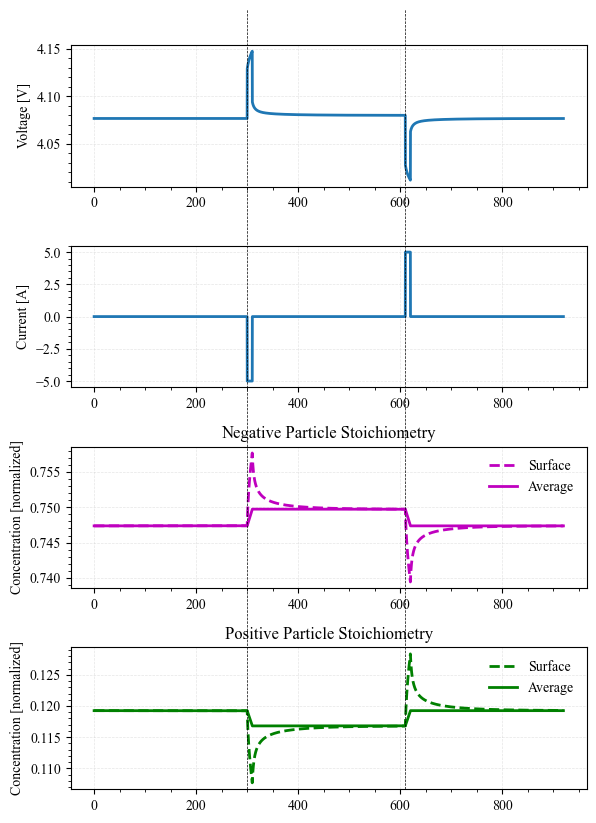

In [72]:
fig, axes = plt.subplots(4, 1, figsize=(6, 8))
ax1 = axes.flat[0]
ax2 = axes.flat[1]
ax3 = axes.flat[2]
ax4 = axes.flat[3]
ax1.plot(t5, V5)
ax1.set_ylabel('Voltage [V]')
ax2.plot(t5, I5)
ax2.set_ylabel('Current [A]')
ax3.plot(t5,cs_sur_n_5,'m--',t5,cs_ave_n_5,'m')
ax3.set_ylabel('Concentration [normalized]')
ax3.legend(['Surface','Average'])
ax3.set_title('Negative Particle Stoichiometry')
ax4.plot(t5,cs_sur_p_5,'g--',t5,cs_ave_p_5,'g')

ax4.set_ylabel('Concentration [normalized]')
ax4.set_title('Positive Particle Stoichiometry')
ax4.legend(['Surface','Average'])
ax4.axvline(x = t_in0, color = 'k', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=5.5)
ax4.axvline(x = t_in0+t_in1+t_in2, color = 'k', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=5.5)
# ax1.set_xlim([20370,20470])
# ax1.legend(['data','sim'])
fig.tight_layout()
plt.savefig('cell_01_pulse_V_sam.png')

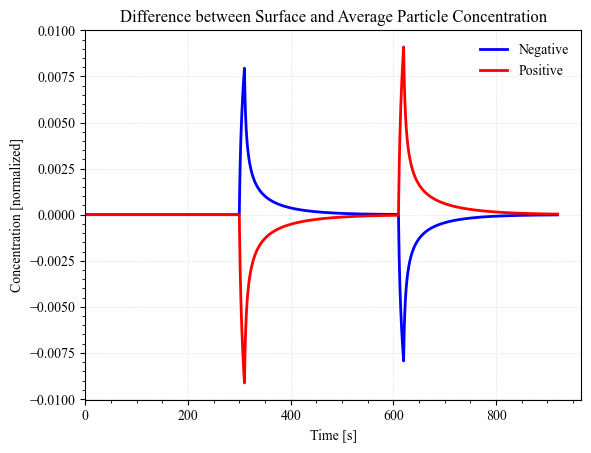

In [56]:
plt.figure()
plt.plot(t5,cs_sur_n_5-cs_ave_n_5,'b')
plt.plot(t5,cs_sur_p_5-cs_ave_p_5,'r')
plt.xlim(left=0)
plt.xlabel('Time [s]')
plt.ylabel('Concentration [normalized]')
plt.title('Difference between Surface and Average Particle Concentration')
plt.legend(['Negative','Positive'])
# plt.savefig('cell_01_conc_V.png')